# Chlorophyll vs Control (Masking SPECTRA's chlorophyll to only show output where there are observations at SeaWiFS)

In [2]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

In [3]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

In [4]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [5]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## Seasonality in both SPECTRA and SeaWIFS throughout the Arctic

In [6]:
jluo_chl_file = '/glade/work/jluo/obs/SeaWiFS/climatology_regridded'
obsfiles = sorted(glob.glob(f'{jluo_chl_file}/*L3m_MC_CHL_chl_ocx_gx1v6.nc', recursive=True),
                      key=numericalSort)
obs = xr.open_mfdataset(obsfiles,combine='by_coords')

In [7]:
# Obs is the chlorophyll from SeaWiFs that is under Jessica's file. A climatology of all the years that it has... 
obs

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, time: 12)
Coordinates:
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 ... 376 377 378 379 380 381 382 383
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
  * time     (time) int64 15 45 74 104 135 166 196 227 258 288 319 349
Data variables:
    chl_ocx  (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    TLONG    (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    TLAT     (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>

## Now check the seasonality

In [11]:
file = '/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_2ndcycle_1990-2009_clim/regrid/'
ice_inds = sorted(glob.glob(f'{file}regrid_GNG595_ECOSYS_IFRAC.*.nc', recursive=True))
ice_ds = xr.open_mfdataset(ice_inds,combine='by_coords')

In [12]:
PAR_inds = sorted(glob.glob(f'{file}regrid_GNG595_PAR_avg.*.nc', recursive=True))
PAR_ds = xr.open_mfdataset(PAR_inds,combine='by_coords')

In [13]:
ice_ds.ECOSYS_IFRAC.shape

(12, 180, 360)

In [14]:
PAR_ds.PAR_avg.shape

(12, 15, 180, 360)

In [15]:
# Model ice for every region 
ice_ao = np.nanmean(ice_ds.ECOSYS_IFRAC[:,170:180,:], axis=(1,2))
ice_cs = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,0:25], axis = (1,2))
ice_bs = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,25:55], axis = (1,2))
ice_ca = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,55:110], axis = (1,2))
ice_bb = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,110:135], axis = (1,2))
ice_ess = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,325:360], axis = (1,2))
ice_ls = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,270:325], axis = (1,2))
ice_ns = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,155:205], axis = (1,2))
ice_bts =np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,205:233], axis = (1,2))
ice_ks = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,233:270], axis = (1,2))

# Model ice for every region 
PAR_ao = np.nanmean(PAR_ds.PAR_avg[:,0,170:180,:], axis=(1,2))
PAR_cs = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,0:25], axis = (1,2))
PAR_bs = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,25:55], axis = (1,2))
PAR_ca = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,55:110], axis = (1,2))
PAR_bb = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,110:135], axis = (1,2))
PAR_ess = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,325:360], axis = (1,2))
PAR_ls = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,270:325], axis = (1,2))
PAR_ns = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,155:205], axis = (1,2))
PAR_bts =np.nanmean(PAR_ds.PAR_avg[:,0,149:170,205:233], axis = (1,2))
PAR_ks = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,233:270], axis = (1,2))


## Add interannual variability in SeaWiFS Chlorophyll

In [16]:
# October, November and December of 1997 
seawifs_data = '/glade/derecho/scratch/gabyn/obs/SeaWiFS/interannual_1997_2010'
obs_1997 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_1997.*.nc', recursive=True),
                      key=numericalSort)
ds_1997 = xr.open_mfdataset(obs_1997,concat_dim='time',combine='nested')

# All months of 1998
obs_1998 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_1998.*.nc', recursive=True),
                      key=numericalSort)
ds_1998 = xr.open_mfdataset(obs_1998,concat_dim='time',combine='nested')

# All months of 1999
obs_1999 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_1999.*.nc', recursive=True),
                      key=numericalSort)
ds_1999 = xr.open_mfdataset(obs_1999,concat_dim='time',combine='nested')

# All months of 2000
obs_2000 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_2000.*.nc', recursive=True),
                      key=numericalSort)
ds_2000 = xr.open_mfdataset(obs_2000,concat_dim='time',combine='nested')

# All months of 2001
obs_2001 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_2001.*.nc', recursive=True),
                      key=numericalSort)
ds_2001 = xr.open_mfdataset(obs_2001,concat_dim='time',combine='nested')

# All months of 2002
obs_2002 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_2002.*.nc', recursive=True),
                      key=numericalSort)
ds_2002 = xr.open_mfdataset(obs_2002,concat_dim='time',combine='nested')

# All months of 2003
obs_2003 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_2003.*.nc', recursive=True),
                      key=numericalSort)
ds_2003 = xr.open_mfdataset(obs_2003,concat_dim='time',combine='nested')

# All months of 2004
obs_2004 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_2004.*.nc', recursive=True),
                      key=numericalSort)
ds_2004 = xr.open_mfdataset(obs_2004,concat_dim='time',combine='nested')

# All months of 2005
obs_2005 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_2005.*.nc', recursive=True),
                      key=numericalSort)
ds_2005 = xr.open_mfdataset(obs_2005,concat_dim='time',combine='nested')

# All months of 2006
obs_2006 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_2006.*.nc', recursive=True),
                      key=numericalSort)
ds_2006 = xr.open_mfdataset(obs_2006,concat_dim='time',combine='nested')

# All months of 2007
obs_2007 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_2007.*.nc', recursive=True),
                      key=numericalSort)
ds_2007 = xr.open_mfdataset(obs_2007,concat_dim='time',combine='nested')

# Only 10 months, February and March are Absent. 
obs_2008 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_2008.*.nc', recursive=True),
                      key=numericalSort)
ds_2008 = xr.open_mfdataset(obs_2008,concat_dim='time',combine='nested')

# May, and December are absent. 
obs_2009 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_2009.*.nc', recursive=True),
                      key=numericalSort)
ds_2009 = xr.open_mfdataset(obs_2009,concat_dim='time',combine='nested')

# All months of 2010
obs_2010 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_2010.*.nc', recursive=True),
                      key=numericalSort)
ds_2010 = xr.open_mfdataset(obs_2010,concat_dim='time',combine='nested')

In [17]:
ds_1997

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 180, time: 4)
Coordinates:
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: time
Data variables:
    chl_ocx  (time, lat, lon) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes: (12/67)
    CDI:                               Climate Data Interface version 2.0.2 (...
    institution:                       NASA Goddard Space Flight Center, Ocea...
    Conventions:                       CF-1.6 ACDD-1.3
    product_name:                      S19972441997273.L3m_MO_CHL_chl_ocx_9km.nc
    instrument:                        SeaWiFS
    title:                             SeaWiFS Level-3 Standard Mapped Image
    ...                                ...
    data_bins:                         3767293
    data_minimum:                      0.002439565
    data_maximum:                      93.69129
    history:                           Sun Jan 22 17:55:21 2023: cdo sellonla...
    NCO:                               netCDF Operators version 5.0.3 (Homepa...
    CDO:                               Climate Data Operators version 2.0.1 (...

In [49]:
# This should be the same as Jessica's but it should be remapped in order to be able to average through... However, I think we can do the average once we have the interannual changes to see how much it does change. 
#regrid_chl = sorted(glob.glob('/glade/u/home/gabyn/obs/SeaWiFS/remap_CHL.*.nc', recursive=True))
#chl_ocx_SeaWiFS_mean = xr.open_mfdataset(regrid_chl,concat_dim='time',combine='nested')

	NC4_open: path /glade/u/home/gabyn/obs/SeaWiFS/remap_CHL.01.nc mode 4096 params 0
	HDF5 error messages turned on.
			nc4_open_file: path /glade/u/home/gabyn/obs/SeaWiFS/remap_CHL.01.nc mode 4096
			nc4_grp_list_add: name / 
			nc4_rec_read_metadata: grp->hdr.name /
			found dataset time
			found dataset lon
			found dataset lat
			found dataset chl_ocx
ERROR: Invalid _NCProperties attribute
		*** NetCDF-4 Internal Metadata: int_ncid 0x4e0000 ext_ncid 0x4e0000
		FILE - path: /glade/u/home/gabyn/obs/SeaWiFS/remap_CHL.01.nc cmode: 0x1008 parallel: 0 redef: 0 fill_mode: 0 no_write: 1 next_nc_grpid: 1
		 GROUP - / nc_grpid: 0 nvars: 4 natts: 0
		 DIMENSION - dimid: 0 name: time len: 1 unlimited: 1
		 DIMENSION - dimid: 1 name: lon len: 360 unlimited: 0
		 DIMENSION - dimid: 2 name: lat len: 180 unlimited: 0
		 VARIABLE - varid: 0 name: time ndims: 1 dimscale: 1 dimids: 0
		 VARIABLE - varid: 1 name: lon ndims: 1 dimscale: 1 dimids: 1
		 VARIABLE - varid: 2 name: lat ndims: 1 dimscale: 1 di

### Make a dummy variable filled with Nans, so that we can create a full 12 month dataset for every year

In [18]:
an_array = np.empty((180,360))
an_array[:] = np.NaN

### Populate the months that do not have data

In [19]:
ds_1997_new = np.stack([an_array,an_array,an_array,an_array,
                       an_array,an_array,an_array,an_array,
                       an_array,ds_1997.chl_ocx[0,:,:],
                       ds_1997.chl_ocx[1,:,:],
                       ds_1997.chl_ocx[2,:,:]])

ds_2008_new = np.stack([ds_2008.chl_ocx[0,:,:],
                        an_array,
                        an_array,
                       ds_2008.chl_ocx[1,:,:],
                       ds_2008.chl_ocx[2,:,:],
                       ds_2008.chl_ocx[3,:,:],
                       ds_2008.chl_ocx[4,:,:],
                       ds_2008.chl_ocx[5,:,:],
                       ds_2008.chl_ocx[6,:,:],
                       ds_2008.chl_ocx[7,:,:],
                       ds_2008.chl_ocx[8,:,:],
                       ds_2008.chl_ocx[9,:,:]])

#ds_2002_new = np.stack([ds_2002.chl_ocx[0,:,:],
#                       ds_2002.chl_ocx[1,:,:],
#                       ds_2002.chl_ocx[2,:,:],
#                        an_array,
#                        an_array,
#                       ds_2002.chl_ocx[3,:,:],
#                       ds_2002.chl_ocx[4,:,:],
#                       ds_2002.chl_ocx[5,:,:],
#                       ds_2002.chl_ocx[6,:,:],
#                       ds_2002.chl_ocx[7,:,:],
#                       ds_2002.chl_ocx[8,:,:],
#                       ds_2002.chl_ocx[9,:,:]])

ds_2009_new = np.stack([ds_2009.chl_ocx[0,:,:],
                       ds_2009.chl_ocx[1,:,:],
                       ds_2009.chl_ocx[2,:,:],
                       ds_2009.chl_ocx[3,:,:],
                        an_array,
                       ds_2009.chl_ocx[4,:,:],
                       ds_2009.chl_ocx[5,:,:],
                       ds_2009.chl_ocx[6,:,:],
                       ds_2009.chl_ocx[7,:,:],
                       ds_2009.chl_ocx[8,:,:],
                       ds_2009.chl_ocx[9,:,:],
                       an_array])

### Create one dataset with all of the months and years! the size should be (14,12,180,360)

In [20]:
chl_ocx_SeaWiFS = np.stack([ds_1997_new, 
                            ds_1998.chl_ocx,
                           ds_1999.chl_ocx,
                           ds_2000.chl_ocx,
                           ds_2001.chl_ocx,
                           ds_2002.chl_ocx,
                           ds_2003.chl_ocx,
                           ds_2004.chl_ocx,
                           ds_2005.chl_ocx,
                           ds_2006.chl_ocx,
                           ds_2007.chl_ocx,
                            ds_2008_new,
                            ds_2009_new,
                           ds_2010.chl_ocx])

In [21]:
chl_ocx_SeaWiFS.shape

(14, 12, 180, 360)

In [22]:
chl_ocx_SeaWiFS_mean = np.nanmean(chl_ocx_SeaWiFS,axis=0)

In [24]:
#regrid_chl = '/glade/u/home/gabyn/scratch/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_'
regrid_chl = '/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_2ndcycle_1990-2009_clim/regrid/regrid_GNG595_'
diat1_inds = sorted(glob.glob(f'{regrid_chl}diat1Chl.*.nc', recursive=True))
diat1_ds = xr.open_mfdataset(diat1_inds,concat_dim='time', combine='nested')

diat2_inds = sorted(glob.glob(f'{regrid_chl}diat2Chl.*.nc', recursive=True))
diat2_ds = xr.open_mfdataset(diat2_inds,concat_dim='time', combine='nested')

diat3_inds = sorted(glob.glob(f'{regrid_chl}diat3Chl.*.nc', recursive=True))
diat3_ds = xr.open_mfdataset(diat3_inds,concat_dim='time', combine='nested')

mp1_inds = sorted(glob.glob(f'{regrid_chl}mp1Chl.*.nc', recursive=True))
mp1_ds = xr.open_mfdataset(mp1_inds,concat_dim='time', combine='nested')

mp2_inds = sorted(glob.glob(f'{regrid_chl}mp2Chl.*.nc', recursive=True))
mp2_ds = xr.open_mfdataset(mp2_inds,concat_dim='time', combine='nested')

mp3_inds = sorted(glob.glob(f'{regrid_chl}mp3Chl.*.nc', recursive=True))
mp3_ds = xr.open_mfdataset(mp3_inds,concat_dim='time', combine='nested')

mp4_inds = sorted(glob.glob(f'{regrid_chl}mp4Chl.*.nc', recursive=True))
mp4_ds = xr.open_mfdataset(mp4_inds,concat_dim='time', combine='nested')

pp_inds = sorted(glob.glob(f'{regrid_chl}ppChl.*.nc', recursive=True))
pp_ds = xr.open_mfdataset(pp_inds,concat_dim='time', combine='nested')

diaz_inds = sorted(glob.glob(f'{regrid_chl}diazChl.*.nc', recursive=True))
diaz_ds = xr.open_mfdataset(diaz_inds,concat_dim='time', combine='nested')

In [25]:
phytoChl = np.stack([pp_ds.ppChl, mp1_ds.mp1Chl, diaz_ds.diazChl, 
                               diat1_ds.diat1Chl, mp2_ds.mp2Chl, diat2_ds.diat2Chl, 
                               mp3_ds.mp3Chl, diat3_ds.diat3Chl, mp4_ds.mp4Chl])

In [30]:
diat1_inds

['/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_2ndcycle_1990-2009_clim/regrid/regrid_GNG595_diat1Chl.01.nc',
 '/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_2ndcycle_1990-2009_clim/regrid/regrid_GNG595_diat1Chl.02.nc',
 '/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_2ndcycle_1990-2009_clim/regrid/regrid_GNG595_diat1Chl.03.nc',
 '/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_2ndcycle_1990-2009_clim/regrid/regrid_GNG595_diat1Chl.04.nc',
 '/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_2ndcycle_1990-2009_clim/regrid/regrid_GNG595_diat1Chl.05.nc',
 '/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_2ndcycle_1990-2009_clim/regrid/regrid_GNG595_diat1Chl.06.nc',
 '/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_2ndcycle_1990-2009_clim/regrid/regrid_GNG595_diat1Chl.07.nc',
 '/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA

In [27]:
phytoChl_surface = np.nansum(phytoChl[:,:,0,:,:], axis =0) 

In [29]:
diat1_ds.diat1Chl.shape

(12, 15, 180, 360)

In [24]:
diat1Chl_ds = diat1_ds.diat1Chl[12:252,0,:,:]
diat1Chl_ds_inter = np.empty([20,12,180,360])
diat1Chl_ds_inter[:] = np.nan
x = np.array(range(0,240,12)) ## this loops from 1990 to 2009, and selects every 12th number. 
for i in range(20):
    diat1Chl_ds_inter[i,:,:,:] = diat1Chl_ds[x[i]:x[i]+12,:,:]

    
diat2Chl_ds = diat2_ds.diat2Chl[12:252,0,:,:]
diat2Chl_ds_inter = np.empty([20,12,180,360])
diat2Chl_ds_inter[:] = np.nan
x = np.array(range(0,240,12)) ## this loops from 1990 to 2009, and selects every 12th number. 
for i in range(20):
    diat2Chl_ds_inter[i,:,:,:] = diat2Chl_ds[x[i]:x[i]+12,:,:]
    
diat3Chl_ds = diat3_ds.diat3Chl[12:252,0,:,:]
diat3Chl_ds_inter = np.empty([20,12,180,360])
diat3Chl_ds_inter[:] = np.nan
x = np.array(range(0,240,12)) ## this loops from 1990 to 2009, and selects every 12th number. 
for i in range(20):
    diat3Chl_ds_inter[i,:,:,:] = diat3Chl_ds[x[i]:x[i]+12,:,:]

In [25]:
diazChl_ds = diaz_ds.diazChl[12:252,0,:,:]
diazChl_ds_inter = np.empty([20,12,180,360])
diazChl_ds_inter[:] = np.nan
x = np.array(range(0,240,12)) ## this loops from 1990 to 2009, and selects every 12th number. 
for i in range(20):
    diazChl_ds_inter[i,:,:,:] = diazChl_ds[x[i]:x[i]+12,:,:]

In [26]:
ppChl_ds = pp_ds.ppChl[12:252,0,:,:]
ppChl_ds_inter = np.empty([20,12,180,360])
ppChl_ds_inter[:] = np.nan
x = np.array(range(0,240,12)) ## this loops from 1990 to 2009, and selects every 12th number. 
for i in range(20):
    ppChl_ds_inter[i,:,:,:] = ppChl_ds[x[i]:x[i]+12,:,:]

In [27]:
mp1Chl_ds = mp1_ds.mp1Chl[12:252,0,:,:]
mp1Chl_ds_inter = np.empty([20,12,180,360])
mp1Chl_ds_inter[:] = np.nan
x = np.array(range(0,240,12)) ## this loops from 1990 to 2009, and selects every 12th number. 
for i in range(20):
    mp1Chl_ds_inter[i,:,:,:] = mp1Chl_ds[x[i]:x[i]+12,:,:]
    
mp2Chl_ds = mp2_ds.mp2Chl[12:252,0,:,:]
mp2Chl_ds_inter = np.empty([20,12,180,360])
mp2Chl_ds_inter[:] = np.nan
x = np.array(range(0,240,12)) ## this loops from 1990 to 2009, and selects every 12th number. 
for i in range(20):
    mp2Chl_ds_inter[i,:,:,:] = mp2Chl_ds[x[i]:x[i]+12,:,:]
    
mp3Chl_ds = mp3_ds.mp3Chl[12:252,0,:,:]
mp3Chl_ds_inter = np.empty([20,12,180,360])
mp3Chl_ds_inter[:] = np.nan
x = np.array(range(0,240,12)) ## this loops from 1990 to 2009, and selects every 12th number. 
for i in range(20):
    mp3Chl_ds_inter[i,:,:,:] = mp3Chl_ds[x[i]:x[i]+12,:,:]
    
mp4Chl_ds = mp4_ds.mp4Chl[12:252,0,:,:]
mp4Chl_ds_inter = np.empty([20,12,180,360])
mp4Chl_ds_inter[:] = np.nan
x = np.array(range(0,240,12)) ## this loops from 1990 to 2009, and selects every 12th number. 
for i in range(20):
    mp4Chl_ds_inter[i,:,:,:] = mp4Chl_ds[x[i]:x[i]+12,:,:]

In [28]:
phytoChl_seasonal = np.stack([ppChl_ds_inter, mp1Chl_ds_inter, diazChl_ds_inter, 
                               diat1Chl_ds_inter, mp2Chl_ds_inter, diat2Chl_ds_inter, 
                               mp3Chl_ds_inter, diat3Chl_ds_inter, mp4Chl_ds_inter])

In [29]:
# Surface Chl.
phytoChl_surface_seasonal = np.nansum(phytoChl_seasonal[:,:,:,:], axis =0)

In [30]:
phytoChl_seasonal.shape

(9, 20, 12, 180, 360)

In [31]:
chl_ocx_SeaWiFS.shape

(14, 12, 180, 360)

In [34]:
chl_ocx_SeaWiFS_mean.shape

(12, 180, 360)

In [35]:
ind_data_01 = np.isnan(chl_ocx_SeaWiFS_mean[0,:,:])
ind_data_02 = np.isnan(chl_ocx_SeaWiFS_mean[1,:,:])
ind_data_03 = np.isnan(chl_ocx_SeaWiFS_mean[2,:,:])
ind_data_04 = np.isnan(chl_ocx_SeaWiFS_mean[3,:,:])
ind_data_05 = np.isnan(chl_ocx_SeaWiFS_mean[4,:,:])
ind_data_06 = np.isnan(chl_ocx_SeaWiFS_mean[5,:,:])
ind_data_07 = np.isnan(chl_ocx_SeaWiFS_mean[6,:,:])
ind_data_08 = np.isnan(chl_ocx_SeaWiFS_mean[7,:,:])
ind_data_09 = np.isnan(chl_ocx_SeaWiFS_mean[8,:,:])
ind_data_10 = np.isnan(chl_ocx_SeaWiFS_mean[9,:,:])
ind_data_11 = np.isnan(chl_ocx_SeaWiFS_mean[10,:,:])
ind_data_12 = np.isnan(chl_ocx_SeaWiFS_mean[11,:,:])

# NOW FOR THE SURFACE
phytoChl_surface_seasonal[:,0,ind_data_01] = np.nan 
phytoChl_surface_seasonal[:,1,ind_data_02] = np.nan
phytoChl_surface_seasonal[:,2,ind_data_03] = np.nan
phytoChl_surface_seasonal[:,3,ind_data_04] = np.nan
phytoChl_surface_seasonal[:,4,ind_data_05] = np.nan
phytoChl_surface_seasonal[:,5,ind_data_06] = np.nan
phytoChl_surface_seasonal[:,6,ind_data_07] = np.nan
phytoChl_surface_seasonal[:,7,ind_data_08] = np.nan
phytoChl_surface_seasonal[:,8,ind_data_09] = np.nan
phytoChl_surface_seasonal[:,9,ind_data_10] = np.nan
phytoChl_surface_seasonal[:,10,ind_data_11] = np.nan
phytoChl_surface_seasonal[:,11,ind_data_12] = np.nan

# Model Chlorophyll for every region (surface)
model_ao_seas = np.nanmean(phytoChl_surface_seasonal[:,:,170:180,:], axis=(0,2,3))
model_cs_seas = np.nanmean(phytoChl_surface_seasonal[:,:,149:170,0:25], axis = (0,2,3))
model_bs_seas = np.nanmean(phytoChl_surface_seasonal[:,:,149:170,25:55], axis = (0,2,3))
model_ca_seas = np.nanmean(phytoChl_surface_seasonal[:,:,149:170,55:110], axis = (0,2,3))
model_bb_seas = np.nanmean(phytoChl_surface_seasonal[:,:,149:170,110:135], axis = (0,2,3))
model_ess_seas = np.nanmean(phytoChl_surface_seasonal[:,:,149:170,325:360], axis = (0,2,3))
model_ls_seas = np.nanmean(phytoChl_surface_seasonal[:,:,149:170,270:325], axis = (0,2,3))
model_ns_seas = np.nanmean(phytoChl_surface_seasonal[:,:,149:170,155:205], axis = (0,2,3))
model_bts_seas =np.nanmean(phytoChl_surface_seasonal[:,:,149:170,205:233], axis = (0,2,3))
model_ks_seas = np.nanmean(phytoChl_surface_seasonal[:,:,149:170,233:270], axis = (0,2,3))

# Model Chlorophyll for every region (surface)
model_ao = np.nanmean(phytoChl_surface_seasonal[:,:,170:180,:], axis=(2,3))
model_cs = np.nanmean(phytoChl_surface_seasonal[:,:,149:170,0:25], axis = (2,3))
model_bs = np.nanmean(phytoChl_surface_seasonal[:,:,149:170,25:55], axis = (2,3))
model_ca = np.nanmean(phytoChl_surface_seasonal[:,:,149:170,55:110], axis = (2,3))
model_bb = np.nanmean(phytoChl_surface_seasonal[:,:,149:170,110:135], axis = (2,3))
model_ess = np.nanmean(phytoChl_surface_seasonal[:,:,149:170,325:360], axis = (2,3))
model_ls = np.nanmean(phytoChl_surface_seasonal[:,:,149:170,270:325], axis = (2,3))
model_ns = np.nanmean(phytoChl_surface_seasonal[:,:,149:170,155:205], axis = (2,3))
model_bts =np.nanmean(phytoChl_surface_seasonal[:,:,149:170,205:233], axis = (2,3))
model_ks = np.nanmean(phytoChl_surface_seasonal[:,:,149:170,233:270], axis = (2,3))

# Obervations, but interannual for the last 20 years 
obs_ao = np.nanmean(chl_ocx_SeaWiFS[:,:,170:180,:], axis=(2,3))
obs_cs = np.nanmean(chl_ocx_SeaWiFS[:,:,149:170,0:25], axis = (2,3))
obs_bs = np.nanmean(chl_ocx_SeaWiFS[:,:,149:170,25:55], axis = (2,3))
obs_ca = np.nanmean(chl_ocx_SeaWiFS[:,:,149:170,55:110], axis = (2,3))
obs_bb = np.nanmean(chl_ocx_SeaWiFS[:,:,149:170,110:135], axis = (2,3))
obs_ess = np.nanmean(chl_ocx_SeaWiFS[:,:,149:170,325:360], axis = (2,3))
obs_ls = np.nanmean(chl_ocx_SeaWiFS[:,:,149:170,270:325], axis = (2,3))
obs_ns = np.nanmean(chl_ocx_SeaWiFS[:,:,149:170,155:205], axis = (2,3))
obs_bts =np.nanmean(chl_ocx_SeaWiFS[:,:,149:170,205:233], axis = (2,3))
obs_ks = np.nanmean(chl_ocx_SeaWiFS[:,:,149:170,233:270], axis = (2,3))

# Observed Chlorophyll for every region. 

obs_ao_seas = np.nanmean(chl_ocx_SeaWiFS_mean[:,170:180,:], axis=(1,2))
obs_cs_seas = np.nanmean(chl_ocx_SeaWiFS_mean[:,149:170,0:25], axis = (1,2))
obs_bs_seas = np.nanmean(chl_ocx_SeaWiFS_mean[:,149:170,25:55], axis = (1,2))
obs_ca_seas = np.nanmean(chl_ocx_SeaWiFS_mean[:,149:170,55:110], axis = (1,2))
obs_bb_seas = np.nanmean(chl_ocx_SeaWiFS_mean[:,149:170,110:135], axis = (1,2))
obs_ess_seas = np.nanmean(chl_ocx_SeaWiFS_mean[:,149:170,325:360], axis = (1,2))
obs_ls_seas = np.nanmean(chl_ocx_SeaWiFS_mean[:,149:170,270:325], axis = (1,2))
obs_ns_seas = np.nanmean(chl_ocx_SeaWiFS_mean[:,149:170,155:205], axis = (1,2))
obs_bts_seas =np.nanmean(chl_ocx_SeaWiFS_mean[:,149:170,205:233], axis = (1,2))
obs_ks_seas = np.nanmean(chl_ocx_SeaWiFS_mean[:,149:170,233:270], axis = (1,2))

In [36]:
model_ao.shape

(20, 12)

In [37]:
obs_ao.shape

(14, 12)

In [38]:
# This is the error on SPECTRA coming from the years
err_aom = np.nanstd(model_ao,axis=0)
err_csm = np.nanstd(model_cs,axis=0)
err_bsm = np.nanstd(model_bs,axis=0)
err_cam = np.nanstd(model_ca,axis=0)
err_bbm = np.nanstd(model_bb,axis=0)
err_essm = np.nanstd(model_ess,axis=0)
err_lsm = np.nanstd(model_ls,axis=0)
err_nsm = np.nanstd(model_ns,axis=0)
err_btsm = np.nanstd(model_bts,axis=0)
err_ksm = np.nanstd(model_ks,axis=0)

# This is the error on the observations
err_ao = np.nanstd(obs_ao,axis=0)
err_cs = np.nanstd(obs_cs,axis=0)
err_bs = np.nanstd(obs_bs,axis=0)
err_ca = np.nanstd(obs_ca,axis=0)
err_bb = np.nanstd(obs_bb,axis=0)
err_ess = np.nanstd(obs_ess,axis=0)
err_ls = np.nanstd(obs_ls,axis=0)
err_ns = np.nanstd(obs_ns,axis=0)
err_bts = np.nanstd(obs_bts,axis=0)
err_ks = np.nanstd(obs_ks,axis=0)

In [74]:
#phytoChl_50m_mean = np.nanmean(phytoChl_50m, axis=0)
phytoChl_surface_mean = np.nanmean(phytoChl_surface_seasonal, axis=0)

In [75]:
phytoChl_surface_mean.shape

(12, 180, 360)

In [39]:
phytoChl_surface_seasonal.shape

(20, 12, 180, 360)

## Font

In [62]:
import matplotlib.pyplot as plt

SMALL_SIZE = 22
MEDIUM_SIZE = 24
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

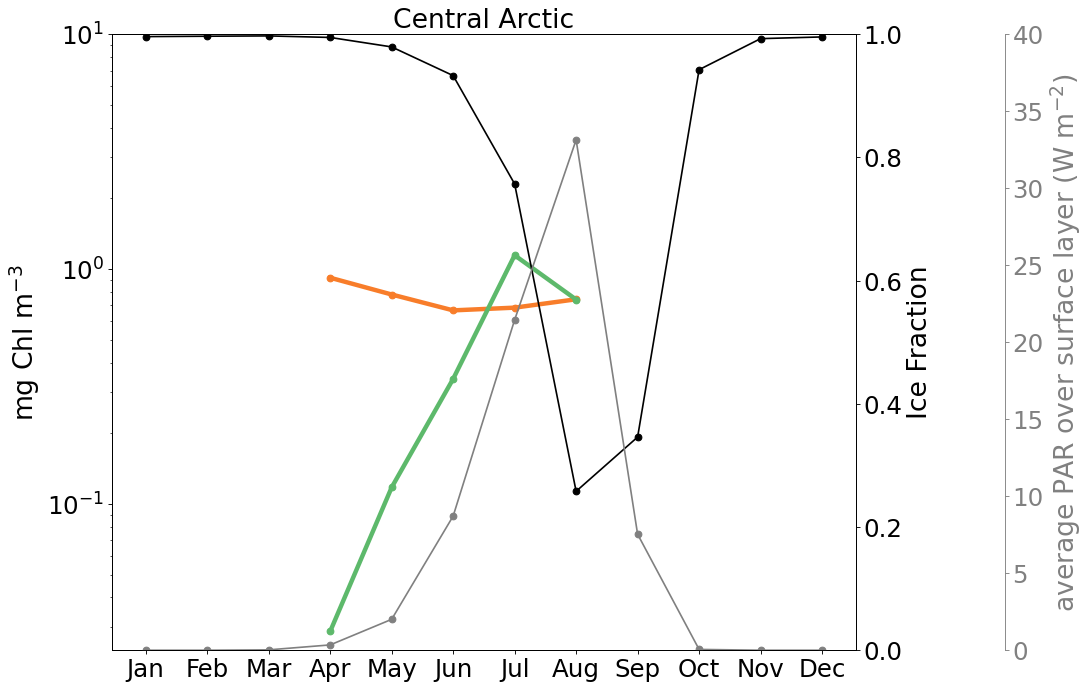

In [114]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
lns1 = ax.plot(months,obs_ao_seas, '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
#ax.fill_between(months, obs_ao_seas-err_ao,obs_ao_seas+err_ao, color=cmap(0))
lns2 = ax.plot(months,model_ao_seas, '-o', color=cmap1(5),linewidth=4,label='MARBL-SPECTRA')
#ax.fill_between(months, model_ao_seas-err_aom,model_ao_seas+err_aom, color=cmap1(1))

#ax.legend(loc='lower right')
plt.yscale("log")
ax.set_ylabel('$mg Chl$ $m^{-3}$', fontsize=24)
ax.set_title('Central Arctic', fontsize=24)

ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
lns4=ax2.plot(months, ice_ao,'-o', color='k',label='Ice-Fraction')
lns5=ax3.plot(months, PAR_ao,'-o', color='gray',label='average PAR')

# added these lines
lns = lns1+lns2+lns4+lns5
labs = [l.get_label() for l in lns]
#ax.legend(lns, labs, fontsize=20,loc="lower left")
ax.legend().remove()
#ax.set_ylim(0,2.5); 
ax2.set_ylim(0,1); ax3.set_ylim(0,40); ax.set_ylim(0,10)
#ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)

# Axes for chlorophyll 
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24); ax.yaxis.label.set_color('k')  
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('average PAR over surface layer (W m$^{-2}$)', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_CentralArctic_seasonality_remap_log.png', dpi=600, bbox_inches='tight')

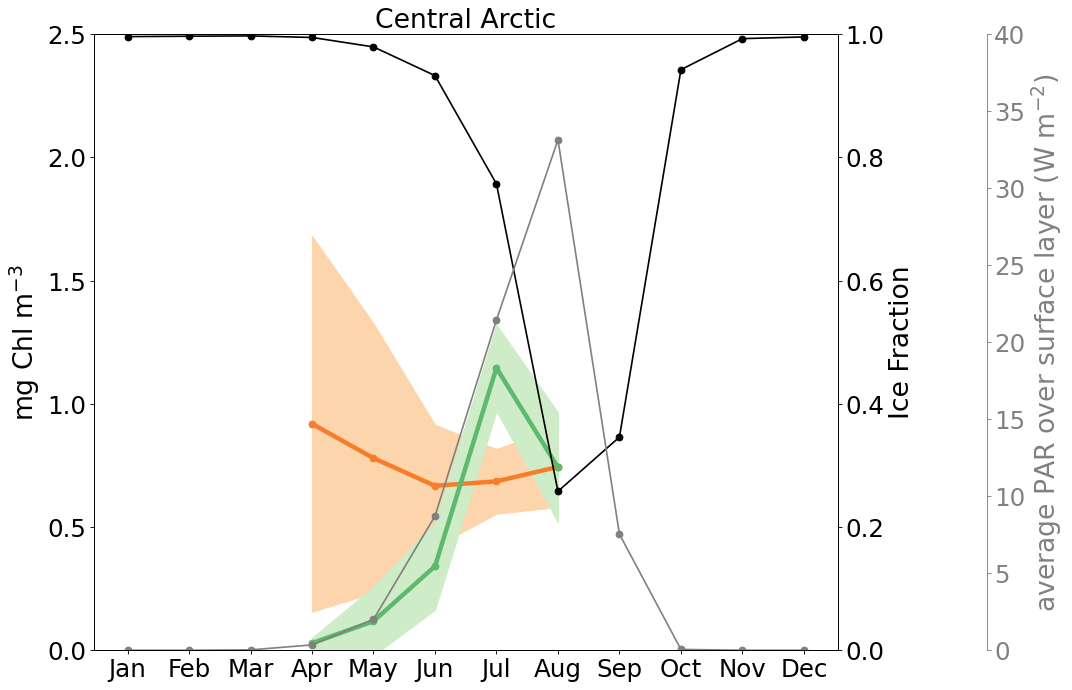

In [69]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
lns1 = ax.plot(months,obs_ao_seas, '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax.fill_between(months, obs_ao_seas-err_ao,obs_ao_seas+err_ao, color=cmap(2))
lns2 = ax.plot(months,model_ao_seas, '-o', color=cmap1(5),linewidth=4,label='MARBL-SPECTRA')
ax.fill_between(months, model_ao_seas-err_aom,model_ao_seas+err_aom, color=cmap1(2))

#ax.legend(loc='lower right')
#plt.yscale("log")
ax.set_ylabel('$mg Chl$ $m^{-3}$', fontsize=24)
ax.set_title('Central Arctic', fontsize=24)

ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
lns4=ax2.plot(months, ice_ao,'-o', color='k',label='Ice-Fraction')
lns5=ax3.plot(months, PAR_ao,'-o', color='gray',label='average PAR')

# added these lines
lns = lns1+lns2+lns4+lns5
labs = [l.get_label() for l in lns]
#ax.legend(lns, labs, fontsize=20,loc="lower left")
ax.legend().remove()
ax.set_ylim(0,2.5); 
ax2.set_ylim(0,1); ax3.set_ylim(0,40)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)

# Axes for chlorophyll 
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24); ax.yaxis.label.set_color('k')  
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('average PAR over surface layer (W m$^{-2}$)', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_CentralArctic_seasonality_remap_sd.png', dpi=600, bbox_inches='tight')

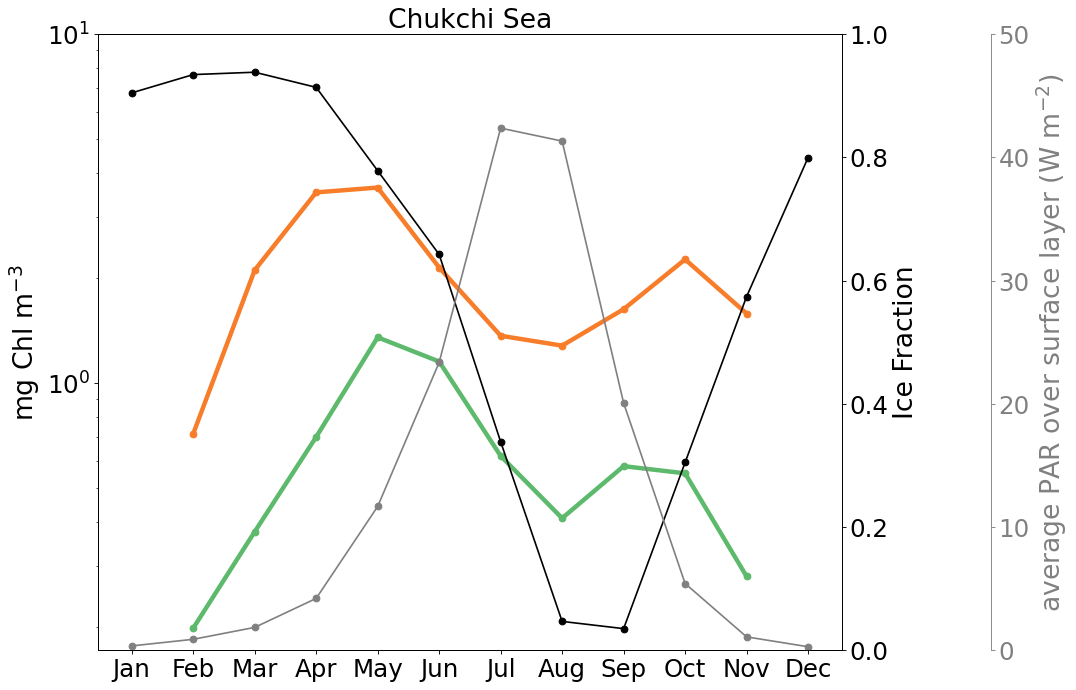

In [113]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_cs_seas, '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax.plot(months,model_cs_seas, '-o', color=cmap1(5),linewidth=4,label='MARBL-SPECTRA (surface)')

plt.yscale("log")
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24)
ax.set_title('Chukchi Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_cs,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_cs,'-o', color='gray',label='PAR Average')

ax2.set_ylim(0,1); ax3.set_ylim(0,50); ax.set_ylim(0,10)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)

# Axes for chlorophyll 
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24); ax.yaxis.label.set_color('k')  
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('average PAR over surface layer (W m$^{-2}$)', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_Chukchi_seasonality_remap_log.png', dpi=600, bbox_inches='tight')

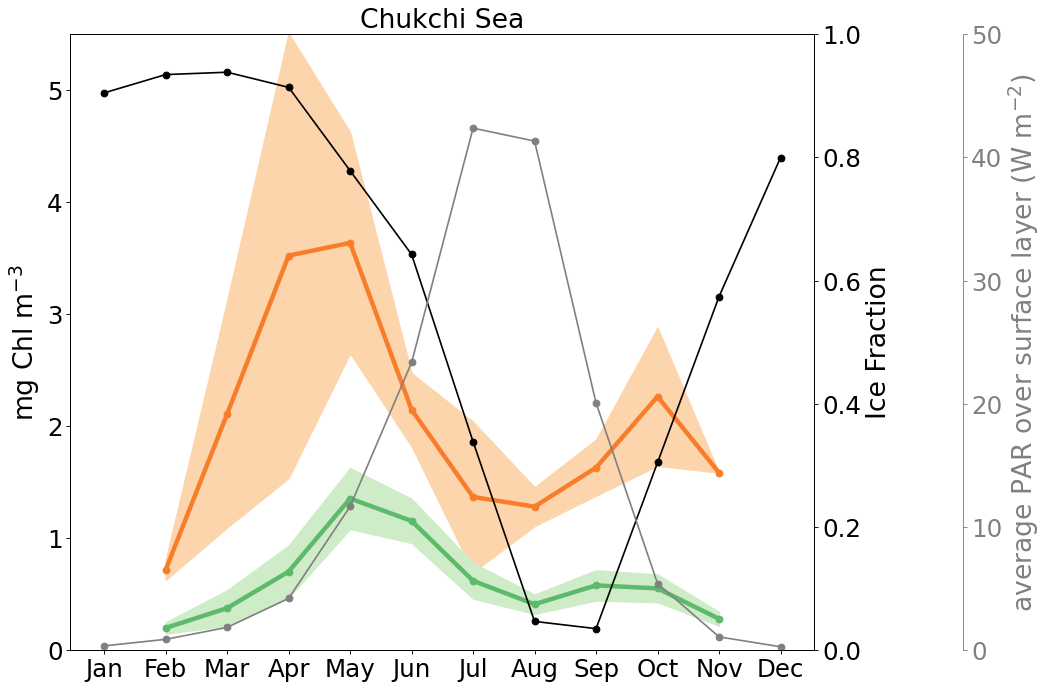

In [75]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_cs_seas, '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax.fill_between(months, obs_cs_seas-err_cs,obs_cs_seas+err_cs, color=cmap(2))
ax.plot(months,model_cs_seas, '-o', color=cmap1(5),linewidth=4,label='SPECTRA (surface)')
ax.fill_between(months, model_cs_seas-err_csm,model_cs_seas+err_csm, color=cmap1(2))

#ax.legend(loc='lower right')
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24)
ax.set_title('Chukchi Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_cs,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_cs,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,5.5); ax2.set_ylim(0,1); ax3.set_ylim(0,50)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)

# Axes for chlorophyll 
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24); ax.yaxis.label.set_color('k')  
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('average PAR over surface layer (W m$^{-2}$)', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_Chukchi_seasonality_remap_sd.png', dpi=600, bbox_inches='tight')

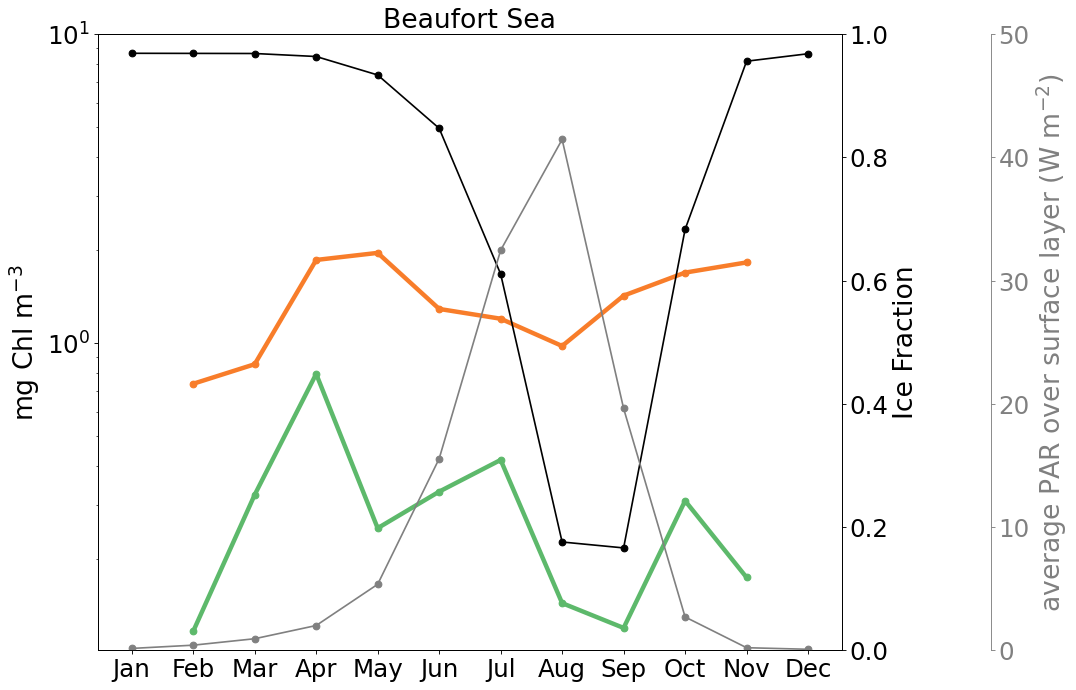

In [112]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_bs_seas, '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax.plot(months,model_bs_seas, '-o', color=cmap1(5),linewidth=4,label='MARBL-SPECTRA')

plt.yscale("log")
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24)
ax.set_title('Beaufort Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_bs,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_bs,'-o', color='gray',label='PAR Average')

ax2.set_ylim(0,1); ax3.set_ylim(0,50); ax.set_ylim(0,10)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
# added these lines
# Axes for chlorophyll 
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24); ax.yaxis.label.set_color('k')  
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('average PAR over surface layer (W m$^{-2}$)', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_Beaufort_seasonality_remap_log.png', dpi=600, bbox_inches='tight')

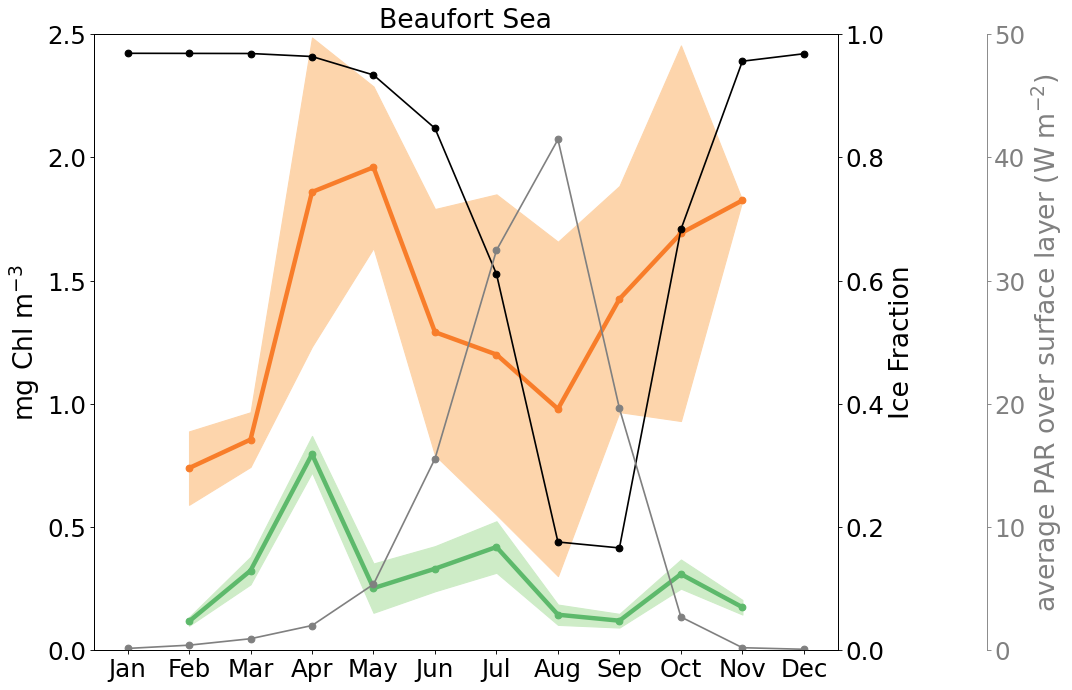

In [77]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_bs_seas, '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax.fill_between(months, obs_bs_seas-err_bs,obs_bs_seas+err_bs, color=cmap(2))
ax.plot(months,model_bs_seas, '-o', color=cmap1(5),linewidth=4,label='MARBL-SPECTRA')
ax.fill_between(months, model_bs_seas-err_bsm,model_bs_seas+err_bsm, color=cmap1(2))


#ax.legend(loc='lower right')
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24)
ax.set_title('Beaufort Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_bs,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_bs,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,2.5); ax2.set_ylim(0,1); ax3.set_ylim(0,50)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
# added these lines
#lns = lns1+lns2+lns4+lns5
#labs = [l.get_label() for l in lns]
#ax.legend().remove()
#ax.legend(lns, labs, fontsize=20,loc="0")
# Axes for chlorophyll 
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24); ax.yaxis.label.set_color('k')  
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('average PAR over surface layer (W m$^{-2}$)', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_Beaufort_seasonality_remap_sd.png', dpi=600, bbox_inches='tight')

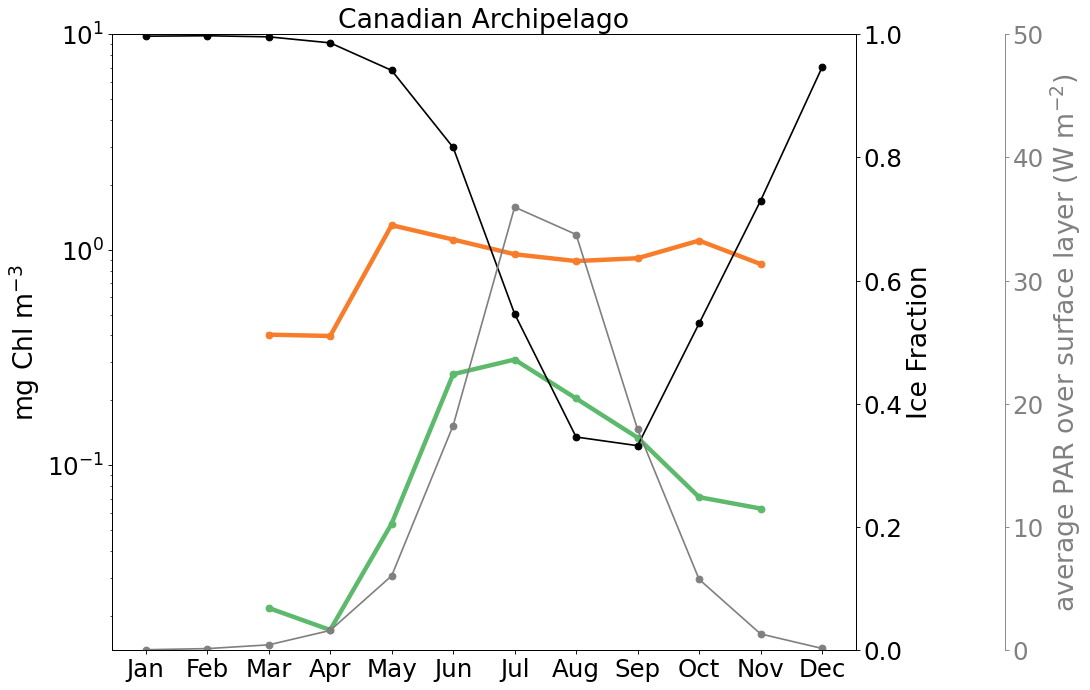

In [111]:
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')
fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ca_seas, '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax.plot(months,model_ca_seas, '-o', color=cmap1(5),linewidth=4,label='SPECTRA (surface)')

plt.yscale("log")
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24)
ax.set_title('Canadian Archipelago', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ca,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ca,'-o', color='gray',label='PAR Average')
ax2.set_ylim(0,1); ax3.set_ylim(0,50); ax.set_ylim(0,10)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)

# Axes for chlorophyll 
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24); ax.yaxis.label.set_color('k')  
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('average PAR over surface layer (W m$^{-2}$)', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_Canadian_seasonality_remap_log.png', dpi=600, bbox_inches='tight')

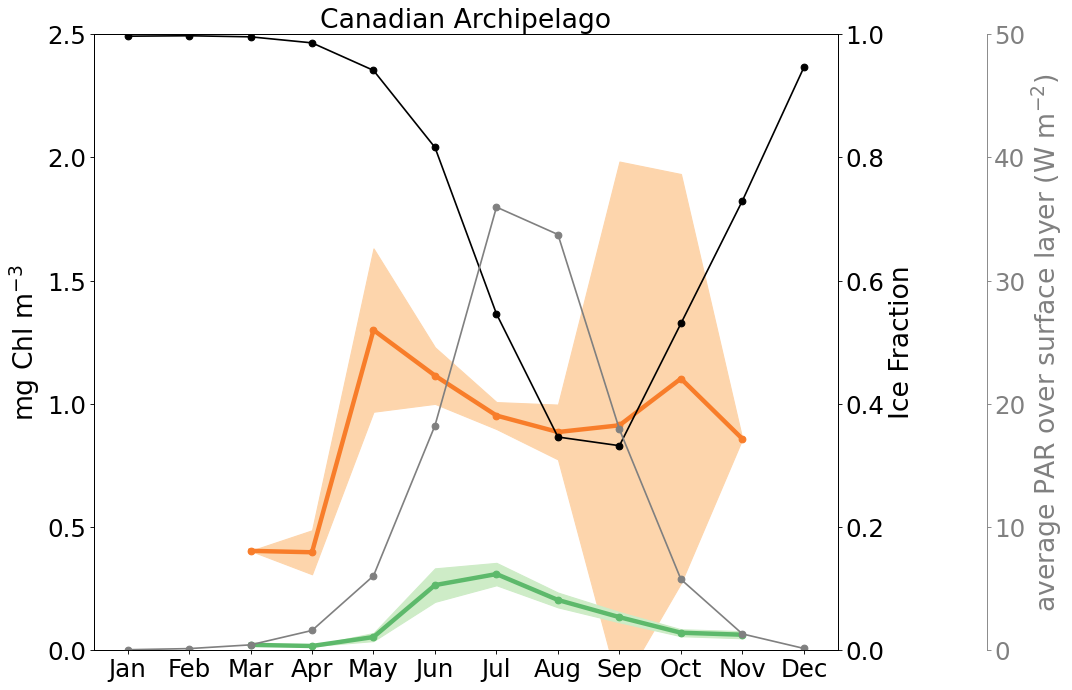

In [78]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')
fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ca_seas, '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax.fill_between(months, obs_ca_seas-err_ca,obs_ca_seas+err_ca, color=cmap(2))
ax.plot(months,model_ca_seas, '-o', color=cmap1(5),linewidth=4,label='SPECTRA (surface)')
ax.fill_between(months, model_ca_seas-err_cam,model_ca_seas+err_cam, color=cmap1(2))

#ax.legend(loc='lower right')
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24)
ax.set_title('Canadian Archipelago', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ca,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ca,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,2.5); ax2.set_ylim(0,1); ax3.set_ylim(0,50)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
# added these lines
#lns = lns1+lns2+lns3+lns4+lns5
#labs = [l.get_label() for l in lns]
#ax.legend(lns, labs, loc="0")
# Axes for chlorophyll 
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24); ax.yaxis.label.set_color('k')  
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('average PAR over surface layer (W m$^{-2}$)', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_Canadian_seasonality_remap_sd.png', dpi=600, bbox_inches='tight')

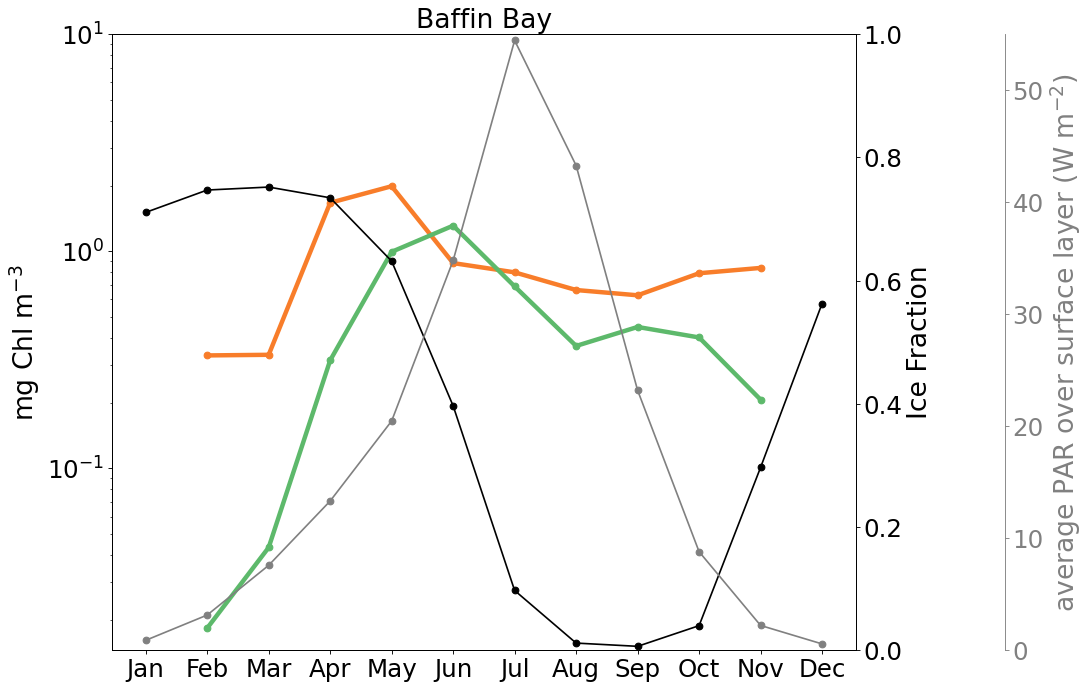

In [110]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_bb_seas, '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax.plot(months,model_bb_seas, '-o', color=cmap1(5),linewidth=4,label='SPECTRA (surface)')


plt.yscale("log")
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24)
ax.set_title('Baffin Bay', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_bb,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_bb,'-o', color='gray',label='PAR Average')

#ax.set_ylim(0,2.5); 
ax2.set_ylim(0,1); ax3.set_ylim(0,55); ax.set_ylim(0,10)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
# Axes for chlorophyll 
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24); ax.yaxis.label.set_color('k')  
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('average PAR over surface layer (W m$^{-2}$)', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_Baffin_seasonality_remap_log.png', dpi=600, bbox_inches='tight')

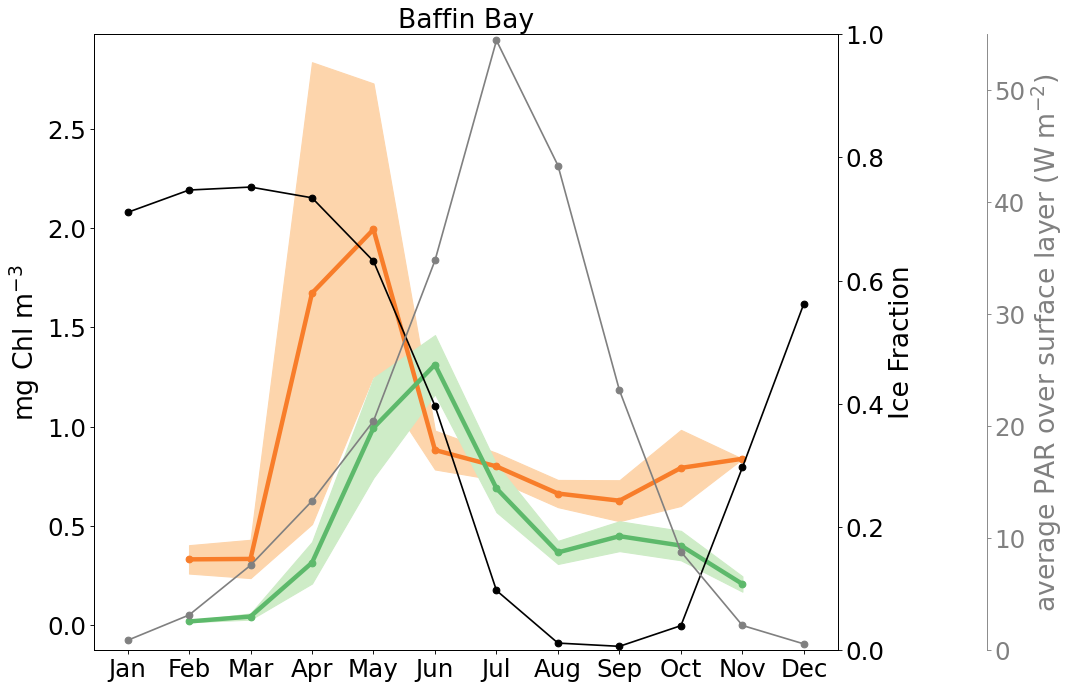

In [81]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_bb_seas, '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax.fill_between(months, obs_bb_seas-err_bb,obs_bb_seas+err_bb, color=cmap(2))
ax.plot(months,model_bb_seas, '-o', color=cmap1(5),linewidth=4,label='SPECTRA (surface)')
ax.fill_between(months, model_bb_seas-err_bbm,model_bb_seas+err_bbm, color=cmap1(2))

#ax.legend(loc='lower right')
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24)
ax.set_title('Baffin Bay', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_bb,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_bb,'-o', color='gray',label='PAR Average')
ax2.set_ylim(0,1); ax3.set_ylim(0,55)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
# Axes for chlorophyll 
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24); ax.yaxis.label.set_color('k')  
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('average PAR over surface layer (W m$^{-2}$)', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_Baffin_seasonality_remap_sd.png', dpi=600, bbox_inches='tight')

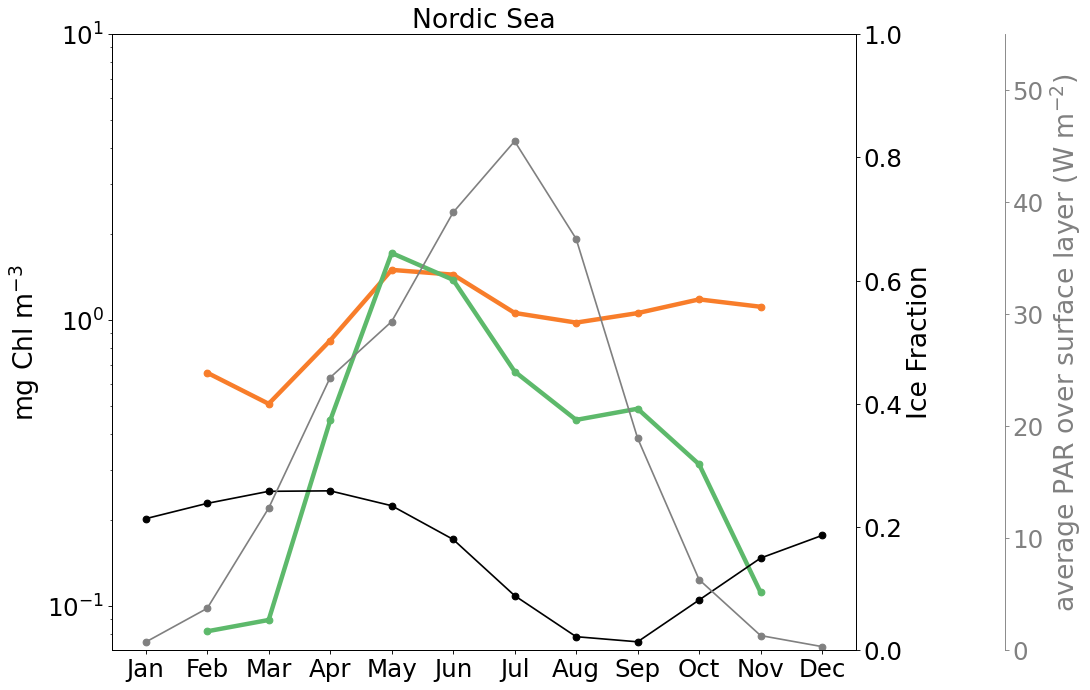

In [109]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ns_seas, '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax.plot(months,model_ns_seas, '-o', color=cmap1(5),linewidth=4,label='MARBL-SPECTRA')

plt.yscale("log")
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24)
ax.set_title('Nordic Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ns,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ns,'-o', color='gray',label='PAR Average')
ax2.set_ylim(0,1); ax3.set_ylim(0,55); ax.set_ylim(0,10)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)

# Axes for chlorophyll 
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24); ax.yaxis.label.set_color('k')  
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('average PAR over surface layer (W m$^{-2}$)', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_Nordic_seasonality_remap_log.png', dpi=600, bbox_inches='tight')

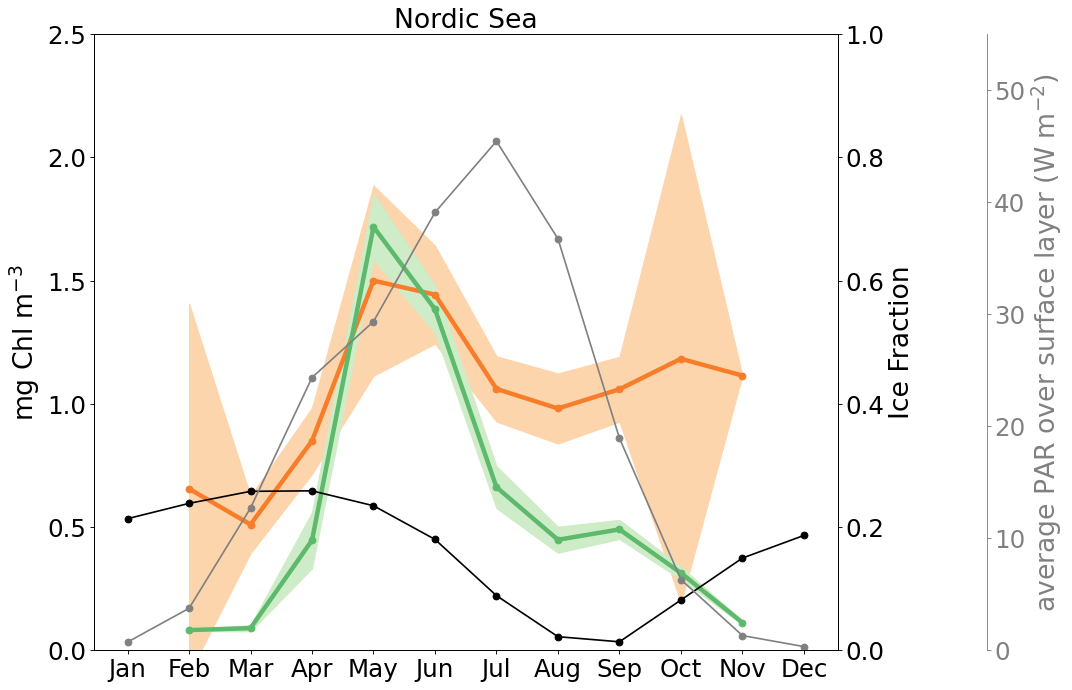

In [83]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ns_seas, '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax.fill_between(months, obs_ns_seas-err_ns,obs_ns_seas+err_ns, color=cmap(2))
ax.plot(months,model_ns_seas, '-o', color=cmap1(5),linewidth=4,label='MARBL-SPECTRA')
ax.fill_between(months, model_ns_seas-err_nsm,model_ns_seas+err_nsm, color=cmap1(2))

#ax.legend(loc='lower right')
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24)
ax.set_title('Nordic Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ns,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ns,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,2.5); ax2.set_ylim(0,1); ax3.set_ylim(0,55)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
# added these lines
#lns = lns1+lns2+lns4+lns5
#labs = [l.get_label() for l in lns]
#ax.legend(lns, labs, fontsize=20,loc="0")
# Axes for chlorophyll 
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24); ax.yaxis.label.set_color('k')  
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('average PAR over surface layer (W m$^{-2}$)', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_Nordic_seasonality_remap_sd.png', dpi=600, bbox_inches='tight')

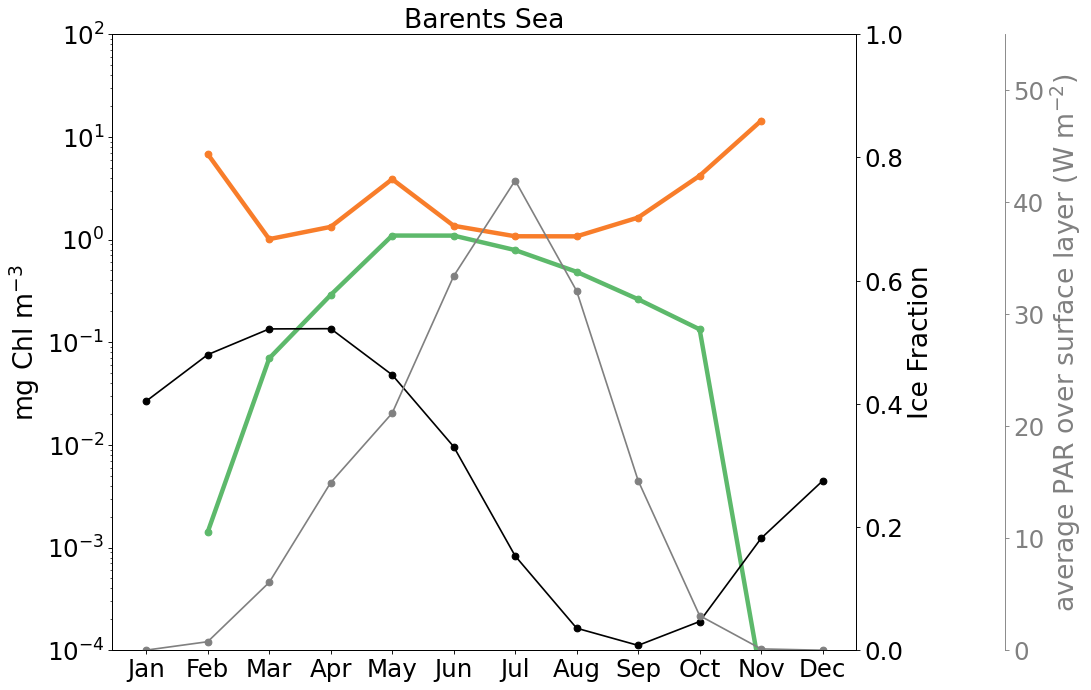

In [102]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_bts_seas, '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax.plot(months,model_bts_seas, '-o', color=cmap1(5),linewidth=4,label='SPECTRA (surface)')
plt.yscale("log")
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24)
ax.set_title('Barents Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_bts,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_bts,'-o', color='gray',label='PAR Average')
ax.set_ylim(0.0001,100)
ax2.set_ylim(0,1); ax3.set_ylim(0,55)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
# Axes for chlorophyll 
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24); ax.yaxis.label.set_color('k')  
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('average PAR over surface layer (W m$^{-2}$)', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_Barents_seasonality_remap_log.png', dpi=600, bbox_inches='tight')

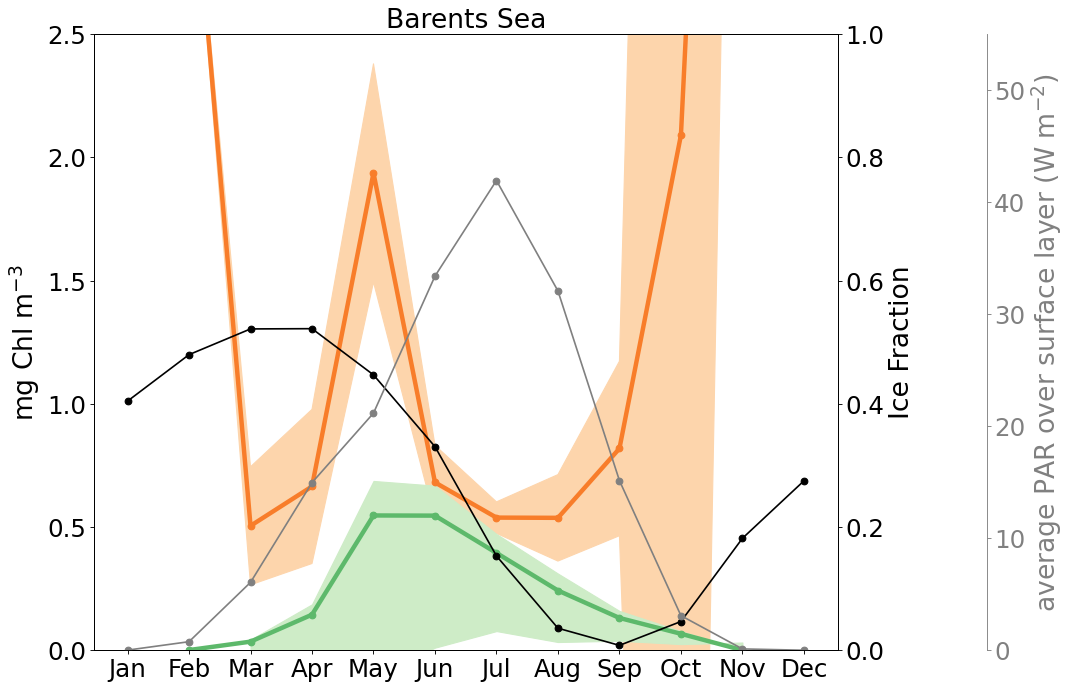

In [100]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_bts_seas, '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax.fill_between(months, obs_bts_seas-err_bts,obs_bts_seas+err_bts, color=cmap(2))
ax.plot(months,model_bts_seas, '-o', color=cmap1(5),linewidth=4,label='SPECTRA (surface)')
ax.fill_between(months, model_ca_seas-err_btsm,model_bts_seas+err_btsm, color=cmap1(2))
#ax.plot(months,model_ca_50m_seas, '-o', color=cmap1(5),linewidth=4,label='SPECTRA (50m vertically weighted)')
#ax.fill_between(months, model_bts_50m_seas-err_btsm_50m,model_bts_seas+err_btsm_50m, color=cmap1(1))

#ax.legend(loc='lower right')
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24)
ax.set_title('Barents Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_bts,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_bts,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,5.0); ax2.set_ylim(0,1); ax3.set_ylim(0,55)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)

# Axes for chlorophyll 
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24); ax.yaxis.label.set_color('k')  
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('average PAR over surface layer (W m$^{-2}$)', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_Barents_seasonality_remap_sd.png', dpi=600, bbox_inches='tight')

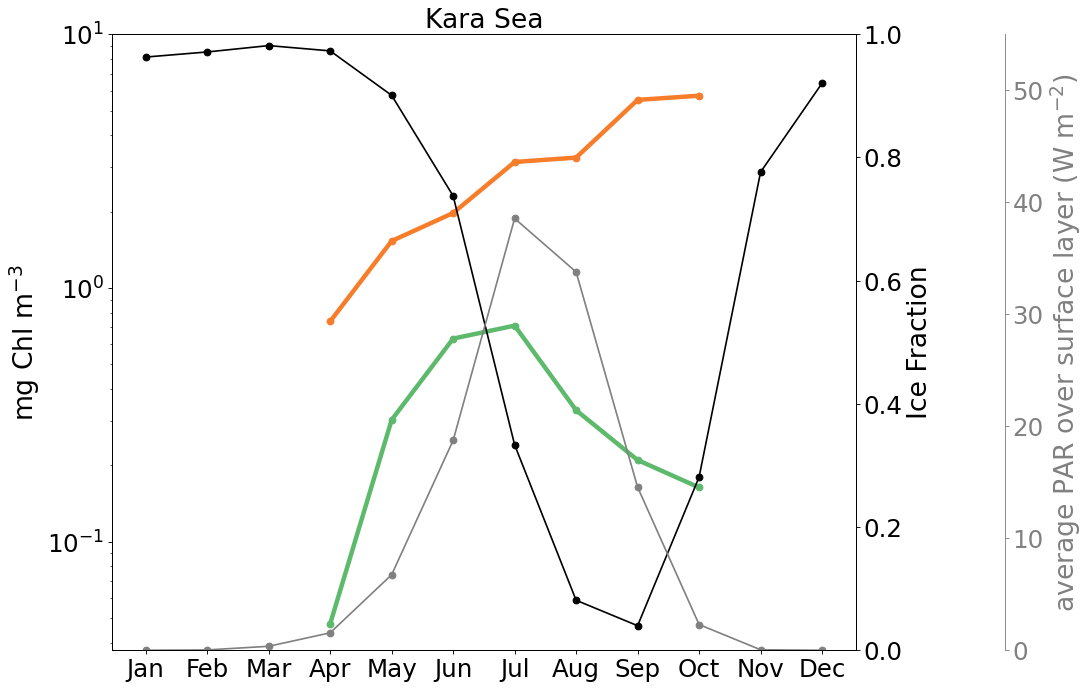

In [104]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ks_seas, '-o', color=cmap(5),linewidth=4,label='SeaWiFS')

ax.plot(months,model_ks_seas, '-o', color=cmap1(5),linewidth=4,label='SPECTRA (surface)')


plt.yscale("log")
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24)
ax.set_title('Kara Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ks,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ks,'-o', color='gray',label='PAR Average')
ax.set_ylim(0,10)
ax2.set_ylim(0,1); ax3.set_ylim(0,55)

ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)

# Axes for chlorophyll 
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24); ax.yaxis.label.set_color('k')  
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('average PAR over surface layer (W m$^{-2}$)', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_Kara_seasonality_remap_log.png', dpi=600, bbox_inches='tight')

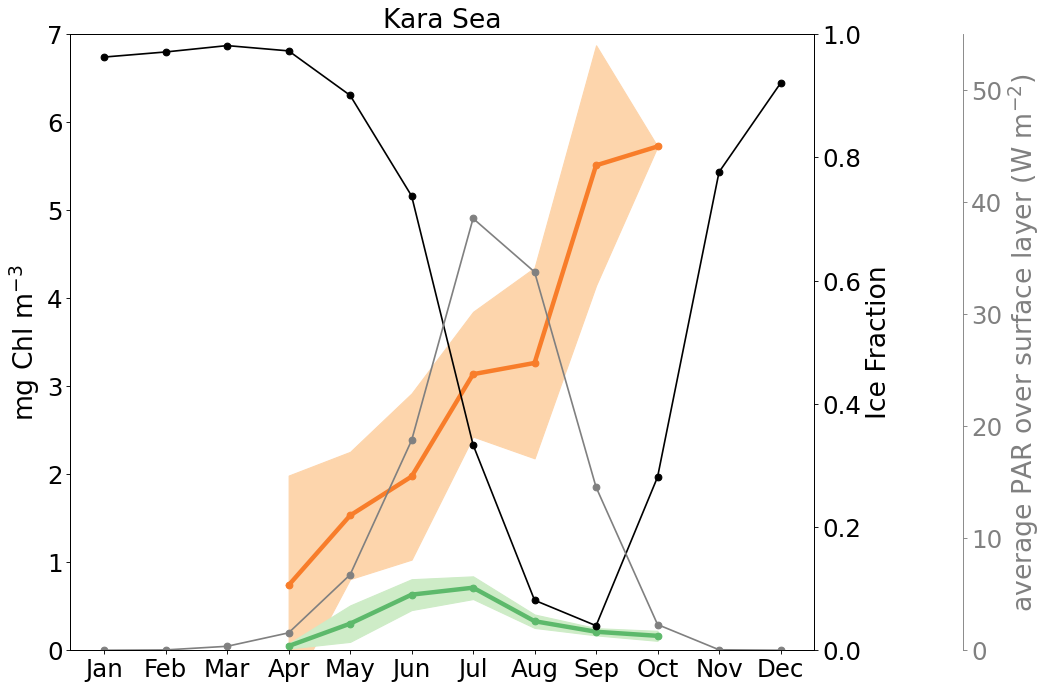

In [90]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ks_seas, '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax.fill_between(months, obs_ks_seas-err_ks,obs_ks_seas+err_ks, color=cmap(2))
ax.plot(months,model_ks_seas, '-o', color=cmap1(5),linewidth=4,label='SPECTRA (surface)')
ax.fill_between(months, model_ks_seas-err_ksm,model_ks_seas+err_ksm, color=cmap1(2))
#ax.plot(months,model_ks_50m_seas, '-o', color=cmap1(5),linewidth=4,label='SPECTRA (50m vertically weighted)')
#ax.fill_between(months, model_ks_50m_seas-err_ksm_50m,model_ks_seas+err_ksm_50m, color=cmap1(1))


#ax.legend(loc='lower right')
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24)
ax.set_title('Kara Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ks,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ks,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,7.0); ax2.set_ylim(0,1); ax3.set_ylim(0,55)
#ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
# added these lines
#lns = lns1+lns2+lns3+lns4+lns5
#labs = [l.get_label() for l in lns]
#ax.legend(lns, labs, loc="0")
# Axes for chlorophyll 
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24); ax.yaxis.label.set_color('k')  
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('average PAR over surface layer (W m$^{-2}$)', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_Kara_seasonality_remap_sd.png', dpi=600, bbox_inches='tight')

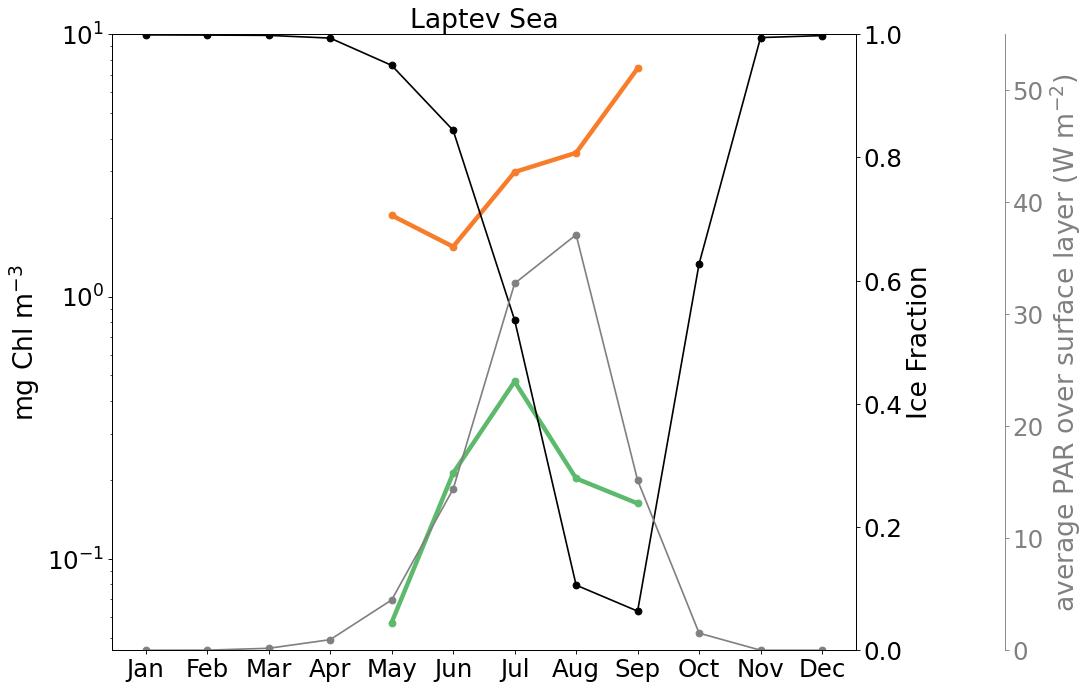

In [ ]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ls_seas, '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax.plot(months,model_ls_seas, '-o', color=cmap1(5),linewidth=4,label='SPECTRA (surface)')
plt.yscale("log")
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24)
ax.set_title('Laptev Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ls,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ls,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,10); ax2.set_ylim(0,1); ax3.set_ylim(0,55)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)

# Axes for chlorophyll 
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24); ax.yaxis.label.set_color('k')  
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('average PAR over surface layer (W m$^{-2}$)', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_Laptev_seasonality_remap_log.png', dpi=600, bbox_inches='tight')

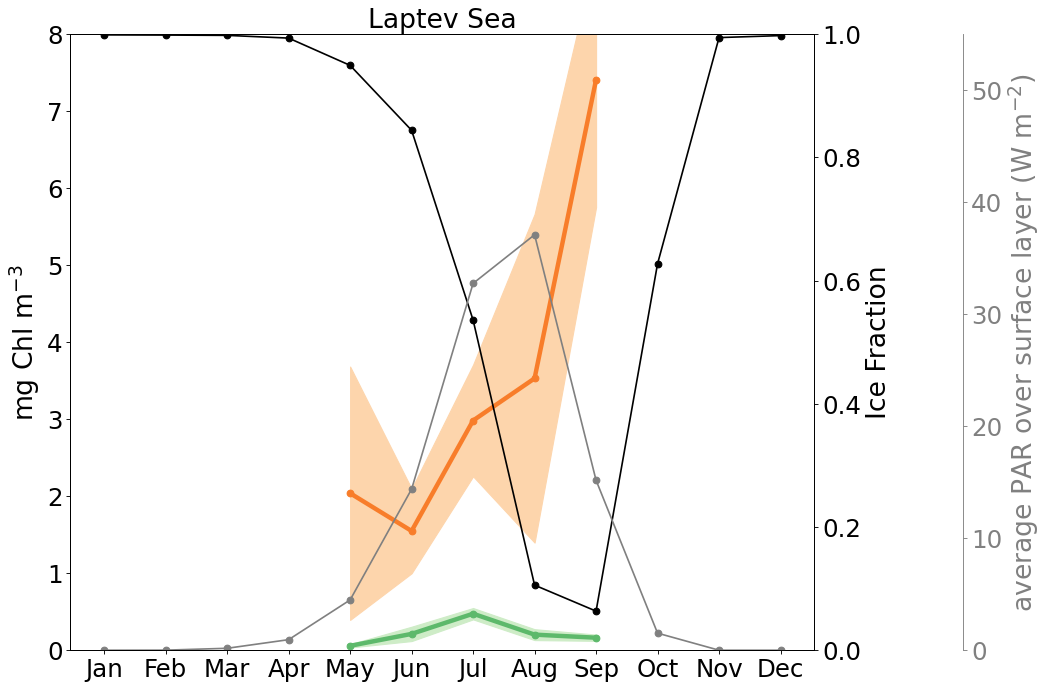

In [107]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ls_seas, '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax.fill_between(months, obs_ls_seas-err_ls,obs_ls_seas+err_ls, color=cmap(2))
ax.plot(months,model_ls_seas, '-o', color=cmap1(5),linewidth=4,label='SPECTRA (surface)')
ax.fill_between(months, model_ls_seas-err_lsm,model_ls_seas+err_lsm, color=cmap1(2))
#ax.plot(months,model_ls_50m_seas, '-o', color=cmap1(5),linewidth=4,label='SPECTRA (50m vertically weighted)')
#ax.fill_between(months, model_ls_50m_seas-err_lsm_50m,model_ls_seas+err_lsm_50m, color=cmap1(1))


#ax.legend(loc='lower right')
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24)
ax.set_title('Laptev Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ls,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ls,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,8.0); ax2.set_ylim(0,1); ax3.set_ylim(0,55)
#ax.set_yticklabels([0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
# added these lines
#lns = lns1+lns2+lns3+lns4+lns5
#labs = [l.get_label() for l in lns]
#ax.legend(lns, labs, loc="0")
# Axes for chlorophyll 
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24); ax.yaxis.label.set_color('k')  
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('average PAR over surface layer (W m$^{-2}$)', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_Laptev_seasonality_remap_sd.png', dpi=600, bbox_inches='tight')

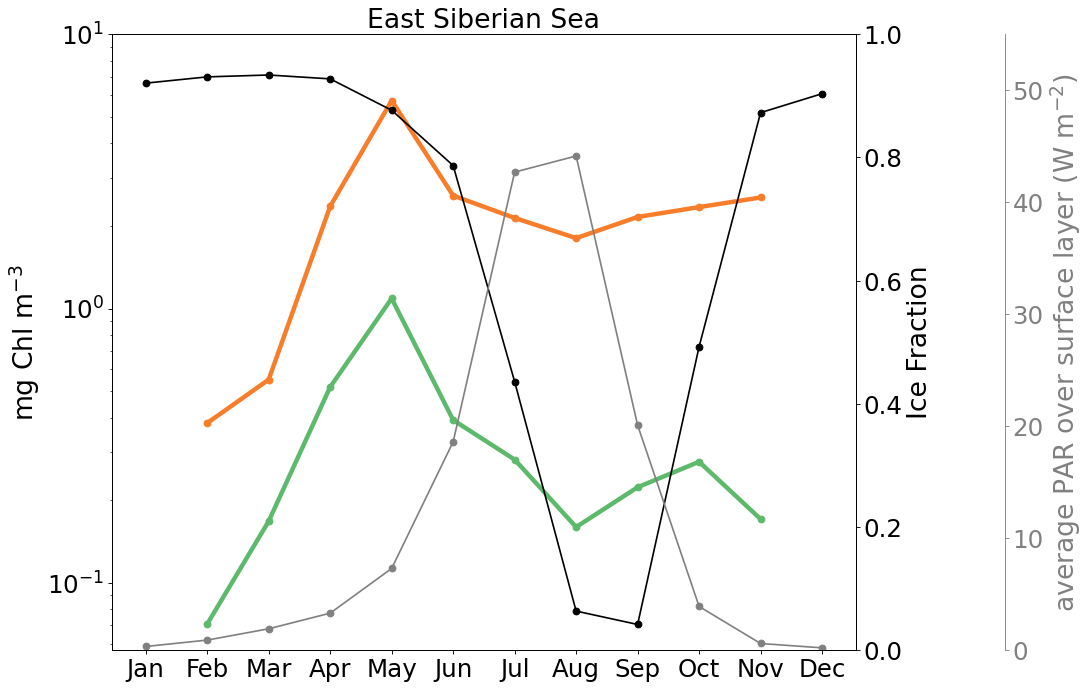

In [108]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ess_seas, '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax.plot(months,model_ess_seas, '-o', color=cmap1(5),linewidth=4,label='SPECTRA (surface)')

plt.yscale("log")
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24)
ax.set_title('East Siberian Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ess,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ess,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,10)
ax2.set_ylim(0,1); ax3.set_ylim(0,55)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
# Axes for chlorophyll 
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24); ax.yaxis.label.set_color('k') 
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('average PAR over surface layer (W m$^{-2}$)', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_EastSiberian_seasonality_remap_log.png', dpi=600, bbox_inches='tight')

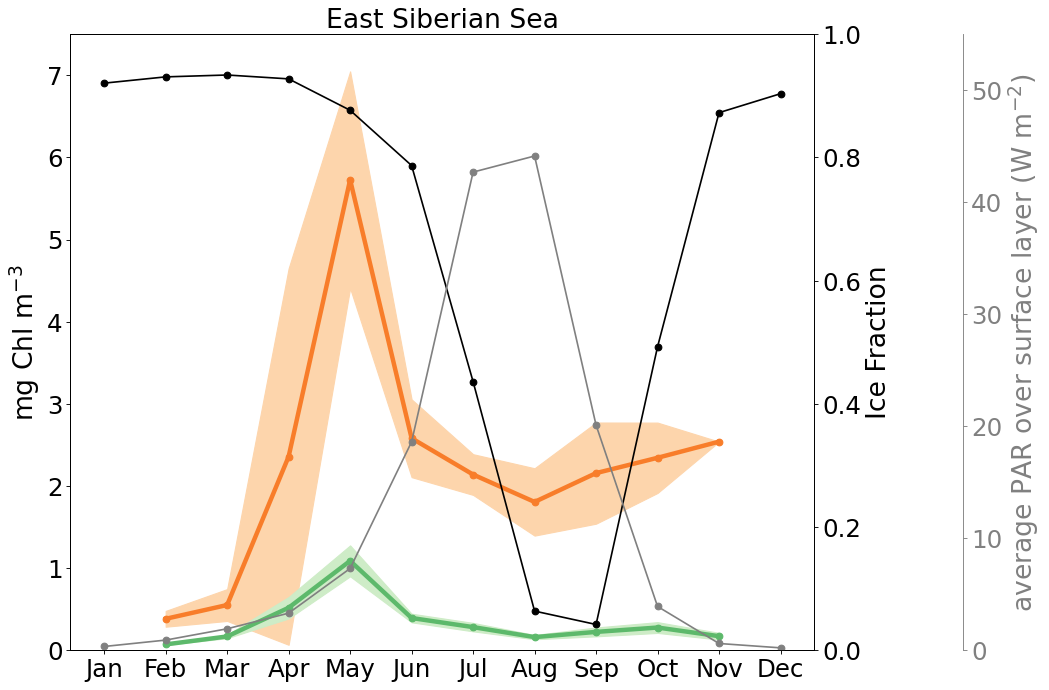

In [98]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ess_seas, '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax.fill_between(months, obs_ess_seas-err_ess,obs_ess_seas+err_ess, color=cmap(2))
ax.plot(months,model_ess_seas, '-o', color=cmap1(5),linewidth=4,label='SPECTRA (surface)')
ax.fill_between(months, model_ess_seas-err_essm,model_ess_seas+err_essm, color=cmap1(2))
#ax.legend(loc='lower right')
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24)
ax.set_title('East Siberian Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ess,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ess,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,7.5); 
ax2.set_ylim(0,1); ax3.set_ylim(0,55)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
# Axes for chlorophyll 
ax.set_ylabel('mg $Chl$ $m^{-3}$', fontsize=24); ax.yaxis.label.set_color('k') 
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('average PAR over surface layer (W m$^{-2}$)', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_EastSiberian_seasonality_remap_sd.png', dpi=600, bbox_inches='tight')